In [1]:
!pip install fastai==1.0.52
from fastai.text import *

     |████████████████████████████████| 225kB 6.8MB/s 
  Found existing installation: fastai 1.0.55
    Uninstalling fastai-1.0.55:
      Successfully uninstalled fastai-1.0.55


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
path = Path(os.getcwd())
path = path/'gdrive'/'My Drive'
news=path/'Thesis Data'/'full doc csv'
aa=path/'Thesis Data'/'Our dataset'
aa2=path/'Thesis Data'/'AA dataset'
char=path/'Thesis Data'/'char-ulm'
subsets=aa/'subsets'
wiki=path/'Thesis Data'/'wiki_data'/'Wiki'

In [0]:
def testing(dts):
  df = pd.read_csv(dts) 
  text_array = df["text"].tolist()
  print(len(text_array))

  final_preds = []

  for text in text_array:
      preds = learn_cls.predict(text)
      final_preds.append(str(preds[0]))

  targets = df["label"].tolist()

  err=[]
  count =0;
  tst = len(text_array)

  for i in range(tst):
      if(targets[i]==final_preds[i]):
          count = count+1
      else:
  #         print(targets[i] + ", " + final_preds[i] + ';')
          err.append((targets[i],final_preds[i]))
  print("Accuracy: ")
  print(count/tst)
  print(err)
  
  return final_preds,targets

### LM

In [0]:
bs = 32
bptt = 70
vocab = " !\"#$%&'()*+,-./0123456789:;=<>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]^_`abcdefghijklmnopqrstuvwxyz{|}~¥§©±ঃঅআইঈউঊঋএঐওঔকখগঘঙচছজঝঞটঠডঢণতথদধনপফবভমযরলশষসহ়ািীুূৃেৈোৌ্ৎৗড়ঢ়য়০১২৩৪৫৬৭৮৯৷‘’‚“”‪™−√∝∞"

In [0]:
class NewTokenizer(BaseTokenizer):
    def tokenizer(self,t):
      return [BOS]+[i for i in t]

In [0]:
itos = [UNK, PAD, BOS, EOS, FLD, TK_REP, TK_WREP] + [i for i in vocab]

In [8]:
len(itos) ##188

188

In [0]:
vocab=Vocab(itos)
tokenizer=Tokenizer(NewTokenizer, pre_rules=[], post_rules=[])

## 6 Authors

### FineTune LM

In [0]:
bs = 128
data_lm=load_data(subsets,'6train_char_lm.pkl',bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,্ র ে দ ে খ ি ত ে ছ ে স ে স ম ্ ব ন ্ ধ ে ত া হ া র ন ি জ ে র য দ ি চ ে ত ন া থ া ক ি ত ত ব ে স ে
1,ি ন ে ই ত া xxunk হ া ক ে এ ক ে ব া র ে শ য ্ য া শ া য় ি ন ী ক র ি য় া দ ি ল xxunk ন ী ল ক ণ ্ ঠ ম ু খ ু য ্ য ে ম শ া
2,় ে ক স প ্ ত া হ য খ ন ত া ক ে অ চ ে ত ন ক র ে ঘ ু ম প া ড ় ি য ় ে র া খ া হ ল ো ত খ ন ো এ ই
3,চ ে আ ছ ি xxunk এ ব xxunk প ্ র ত ি ম ু হ ূ র ্ ত ে আ ল ্ ল া হ র ক া ছ ে প ্ র া র ্ থ ন া ক র ছ ি য ে ন আ ম া
4,ে স ঙ ্ গ ে ন ি য় ে স ে ফ ি র ে ছ ি ল xxunk উ ৎ স ু ক ত ি র ি হ য় ত ো শ ম ি ত ে র শ র ী র ে র অ ব স ্ থ


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=False, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


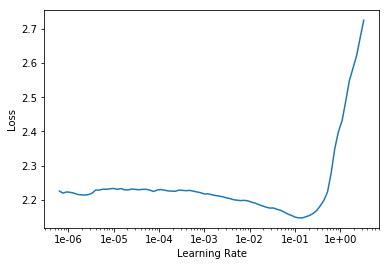

In [0]:
learn.load(wiki/'models'/'wiki_char_15');
learn.lr_find()
learn.recorder.plot()

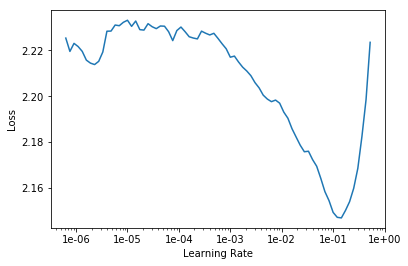

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('6train_wiki_char_lm_head');

epoch,train_loss,valid_loss,accuracy,time
0,1.638759,1.572219,0.540217,17:48
1,1.627931,1.566530,0.541704,17:58


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-2)
learn.save('6train_wiki_char_lm_body_1');

epoch,train_loss,valid_loss,accuracy,time
0,1.370182,1.323461,0.607999,18:39
1,1.331366,1.272717,0.621565,18:33


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-2)
learn.save('6train_wiki_char_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,1.299388,1.254299,0.627072,21:24
1,1.226215,1.196567,0.642620,21:29


In [0]:
learn.load('6train_wiki_char_lm_body_2');
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('6train_wiki_char_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,1.257231,1.232323,0.632917,23:39
1,1.246346,1.215253,0.637848,23:38
2,1.197213,1.170835,0.649604,23:38
3,1.151159,1.152620,0.655028,23:39


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('6train_wiki_char_lm_body_4');

epoch,train_loss,valid_loss,accuracy,time
0,1.219271,1.201828,0.641745,23:33
1,1.217246,1.197109,0.642730,23:29
2,1.177233,1.155826,0.654127,23:20
3,1.142093,1.139255,0.659146,23:18


In [0]:
learn.save_encoder('6train_wiki_char_lm_enc')

### Classification (OUR AA)

In [0]:
data_clas=load_data(subsets,'6train_char_clas.pkl',bs=32)

In [0]:
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('6train_wiki_char_lm_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


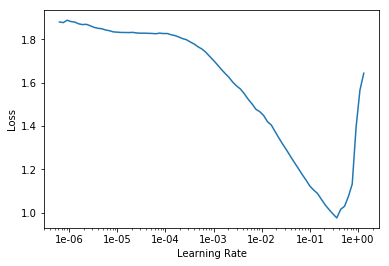

In [0]:
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('6train_wiki_char_cls_1')

epoch,train_loss,valid_loss,accuracy,time
0,0.272784,0.105967,0.967834,17:21
1,0.121405,0.046677,0.985809,17:45


In [0]:
learn_cls.load('6train_wiki_char_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_cls.save('6train_wiki_char_cls_2')

epoch,train_loss,valid_loss,accuracy,time
0,0.085634,0.092793,0.980132,18:44
1,0.075684,0.028112,0.991485,18:32


In [0]:
learn_cls.load('6train_wiki_char_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_cls.save('6train_wiki_char_cls_3')

epoch,train_loss,valid_loss,accuracy,time
0,0.057728,0.027442,0.990539,21:30
1,0.037639,0.023097,0.991485,21:40


In [0]:
learn_cls.load('6train_wiki_char_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('6train_wiki_char_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.021985,0.018940,0.993378,25:37
1,0.026685,0.020304,0.991485,25:38
2,0.027961,0.023919,0.992431,25:44
3,0.025652,0.028301,0.991485,25:28


In [0]:
preds,targ = testing(subsets/'6test.csv')

1320
Accuracy: 
0.9878787878787879
[('MZI', 'humayun_ahmed'), ('MZI', 'humayun_ahmed'), ('shorotchandra', 'robindronath'), ('robindronath', 'shorotchandra'), ('robindronath', 'shorotchandra'), ('robindronath', 'shorotchandra'), ('robindronath', 'shorotchandra'), ('robindronath', 'shorotchandra'), ('robindronath', 'shorotchandra'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'shorotchandra'), ('humayun_ahmed', 'MZI'), ('shomresh', 'robindronath'), ('shunil_gongopaddhay', 'shorotchandra'), ('shunil_gongopaddhay', 'shomresh'), ('shunil_gongopaddhay', 'humayun_ahmed')]


In [0]:
from sklearn.metrics import f1_score
out  = f1_score(targ, preds, average='macro') #'macro' , also == weighted cuz dataset is balanced
out

0.9878965720212983

## 8 Authors

### FineTune LM

In [0]:
bs = 128
data_lm=load_data(subsets,'8train_char_lm.pkl',bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,"স ্ ব া ম ী ব ল ল ে ন , আ ম ি দ ে ব ত া ক ে ম া ন ি , স ে ই জ ন ্ য ে ই অ ন ্ ত র ে র ম ধ ্ য ে ন ি শ ্"
1,( ) - র ব দ ল ে এ খ ন স ি ঙ ্ গ ু ল া র দ ে ( ) ব ্ য ব হ া র ক র া র চ ল শ ু র ু হ য় ে ছ ে xxunk
2,"া য া য় ন া xxunk য ে খ ে ল ে , স ে - ও খ ে ল ো য় া ড় ন য় xxunk য ে গ া ন গ া য় , স ে ই ক ি গ া"
3,ে ন ে ফ ি র ে য া ও য় া র ক ো ন ও ম া ন ে হ য় ন া xxunk স ে দ র জ া প ে র ি য় ে ভ ে ত র ে ঢ ু ক ল !
4,ব স ্ থ া য় ফ ি র ে আ স ত ে প ে র ে ছ ে xxunk ক ী ক র ছ ? ব ি র ক ্ ত ক ো র ো ন া xxunk ক প ট গ া ম ্ ভ ী র


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=False, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


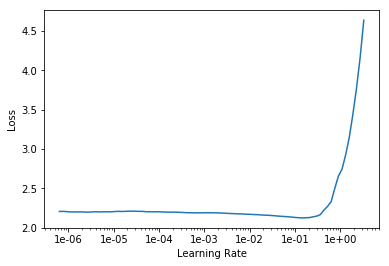

In [0]:
learn.load(wiki/'models'/'wiki_char_15');
learn.lr_find()
learn.recorder.plot()

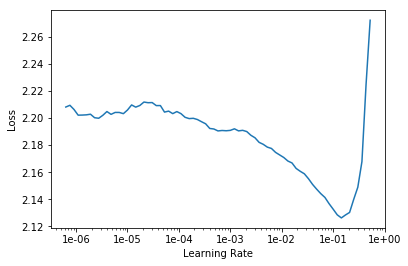

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('8train_wiki_char_lm_head');

epoch,train_loss,valid_loss,accuracy,time
0,1.651353,1.585122,0.536832,21:00
1,1.664516,1.580213,0.538172,20:54


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-2)
learn.save('8train_wiki_char_lm_body_1');

epoch,train_loss,valid_loss,accuracy,time
0,1.415106,1.354406,0.599051,21:39
1,1.357143,1.301274,0.613361,21:39


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-2)
learn.save('8train_wiki_char_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,1.334442,1.290312,0.616575,25:10
1,1.272312,1.223988,0.634645,25:11


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('8train_wiki_char_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,1.299943,1.262082,0.624059,27:46
1,1.278679,1.246743,0.628265,27:46
2,1.228846,1.199525,0.641626,27:47
3,1.202186,1.180660,0.646914,27:48


In [12]:
learn.load('8train_wiki_char_lm_body_3');
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('8train_wiki_char_lm_body_4');

epoch,train_loss,valid_loss,accuracy,time
0,1.258004,1.233102,0.632495,24:26
1,1.259896,1.227281,0.634018,24:25
2,1.212309,1.185657,0.645535,24:27
3,1.173470,1.167343,0.650827,24:26


In [0]:
learn.save_encoder('8train_wiki_char_lm_enc')

### Classification (OUR AA)

In [0]:
data_clas = load_data(subsets, '8train_char_clas.pkl',bs=32)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('8train_wiki_char_lm_enc')

In [15]:
data_clas.show_batch()

text,target
xxbos x x b o s ক ী র ্ ত ি ত ে ত া হ া দ ে র ম ন ে গ র ্ ব ে র স ী ম া র হ ি ল ন া xxunk ব ি ন ্ ধ ্ য ব া স ি ন ী,robindronath
xxbos x x b o s শ ু ন ি য় া হ র ক ু ম া র প ্ র থ ম ট া ভ ী ত হ ই য় া উ ঠ ি ল ে ন ; শ শ ি ভ ূ ষ ণ ক ি ছ ু ত ে ই,robindronath
"xxbos x x b o s গ ্ র া ম ে - গ ঞ ্ জ ে ও এ খ ন ড ি স ্ ক ো চ ল ে , চ ল ে ম ি স স ু ন ্ দ র ী প ্ র ত ি য ো গ ি",toslima_nasrin
"xxbos x x b o s ত া ই ‘ য দ ি স ্ ব া ম ী স ্ ত ্ র ী ক ে আ দ ে শ ক র ে , ত ব ে স ে জ র দ প র ্ ব ত",toslima_nasrin
xxbos x x b o s উ দ ্ দ ে শ ্ য xxunk ক ি ন ্ ত ু স ে দ ি ন এ ই ব ি ভ া গ ট ি ত ে ক ো ন এ ক ট ি স ু র া র ব ্ য,toslima_nasrin


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


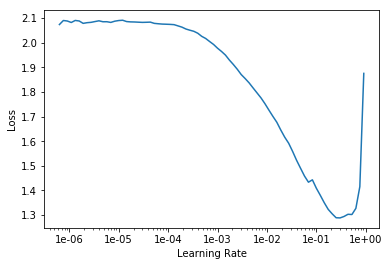

In [16]:
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [17]:
learn_cls.freeze()
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('8train_wiki_char_cls_1')

epoch,train_loss,valid_loss,accuracy,time
0,0.313710,0.101752,0.970613,18:55
1,0.146920,0.074675,0.976490,18:46


In [18]:
learn_cls.load('8train_wiki_char_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_cls.save('8train_wiki_char_cls_2')

epoch,train_loss,valid_loss,accuracy,time
0,0.143984,0.058069,0.983207,19:36
1,0.083310,0.046827,0.985726,19:25


In [19]:
learn_cls.load('8train_wiki_char_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_cls.save('8train_wiki_char_cls_3')

epoch,train_loss,valid_loss,accuracy,time
0,0.062881,0.037048,0.989924,23:00
1,0.048011,0.038641,0.990764,22:47


In [20]:
learn_cls.load('8train_wiki_char_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('8train_wiki_char_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.021179,0.035014,0.990764,25:44
1,0.027770,0.035379,0.991604,25:35
2,0.027454,0.029624,0.991604,25:34
3,0.024530,0.028755,0.992443,25:33


In [21]:
preds,targ = testing(subsets/'8test.csv')

1496
Accuracy: 
0.9866310160427807
[('shirshendu', 'shomresh'), ('shirshendu', 'shomresh'), ('shirshendu', 'shunil_gongopaddhay'), ('shirshendu', 'shomresh'), ('shirshendu', 'shorotchandra'), ('shirshendu', 'robindronath'), ('toslima_nasrin', 'humayun_ahmed'), ('MZI', 'humayun_ahmed'), ('MZI', 'toslima_nasrin'), ('MZI', 'humayun_ahmed'), ('robindronath', 'toslima_nasrin'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'shorotchandra'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'MZI'), ('shomresh', 'shunil_gongopaddhay'), ('shunil_gongopaddhay', 'toslima_nasrin'), ('shunil_gongopaddhay', 'shirshendu'), ('shunil_gongopaddhay', 'robindronath')]


In [22]:
from sklearn.metrics import f1_score
out  = f1_score(targ, preds, average='macro') #'macro' , also == weighted cuz dataset is balanced
out

0.9866071496086541

## 10 Authors

### FineTune LM

In [0]:
bs = 128
data_lm=load_data(subsets,'10train_char_lm.pkl',bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,"র এ ক ট া ফ ু ল গ া ছ ে র ন া ম ব া xxunk দ র ল া ঠ ি ! দ ো ক া ন দ া র ট ি ব ল ল , এ খ া ন থ ে ক ে য া ও"
1,হ ি ল xxunk ল া গ ছ ে ; ব ু ঝ ত ে প া র ছ ি xxunk অ ন ্ ধ ক া র ে ব ন ব া দ া ড় ে ঘ ো র া ট া স হ জ ক া জ ন য় xxunk
2,ট ্ র া ঙ ্ ক ে ঠ া ক ু র দ া র চ ি ঠ ি প ত ্ র ছ ি ল xxunk ফ ি ত ো য ় ব া xxunk ধ া চ ি ঠ ি র ত া ড় া র ত ল া
3,ে ব ল ে দ া ও আ ম া ক ে স ঙ ্ গ ে ন ি য় ে য ে ত ে xxunk খ া ন ি ক ট া ই ত স ্ ত ু ত ক র ে প া ল দ ে ম
4,ল ে ত ো ত ো র জ য় ে ন ্ ট অ ্ য া ক া উ ন ্ ট ক র ে র া খ া উ চ ি ত xxunk জ য় ে ন ্ ট অ ্ য া ক া উ ন ্ ট


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=False, drop_mult=0.5)

In [0]:
learn.load(wiki/'models'/'wiki_char_15');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


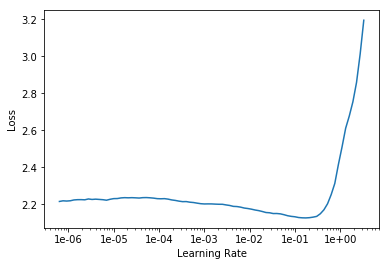

In [0]:
learn.lr_find()
learn.recorder.plot()

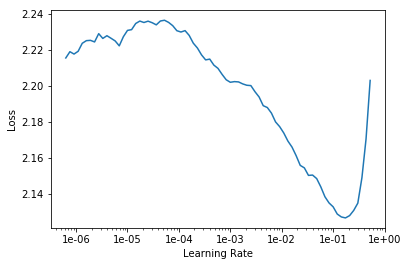

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('10train_wiki_char_lm_head');

epoch,train_loss,valid_loss,accuracy,time
0,1.664490,1.598050,0.534553,22:14
1,1.651965,1.593444,0.535443,22:21


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-2)
learn.save('10train_wiki_char_lm_body_1');

epoch,train_loss,valid_loss,accuracy,time
0,1.411064,1.359388,0.598433,23:15
1,1.364615,1.309998,0.611976,23:17


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-2)
learn.save('10train_wiki_char_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,1.418355,1.352912,0.601810,26:56
1,1.342425,1.297745,0.615911,27:03


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('10train_wiki_char_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,1.318732,1.289895,0.617975,29:38
1,1.296305,1.255059,0.627371,29:33
2,1.248149,1.211005,0.639266,29:35
3,1.205674,1.188828,0.645788,29:36


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('10train_wiki_char_lm_body_4');

epoch,train_loss,valid_loss,accuracy,time
0,1.270261,1.244880,0.630382,29:40
1,1.269940,1.237337,0.632479,29:34
2,1.215266,1.191427,0.645083,29:38
3,1.187250,1.172085,0.650751,29:37


In [0]:
learn.save_encoder('10train_wiki_char_lm_enc')

### Classification (OUR AA)

In [0]:
data_clas = load_data(subsets, '10train_char_clas.pkl',bs=32)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('10train_wiki_char_lm_enc')

In [0]:
data_clas.show_batch()

text,target
xxbos x x b o s গ xxunk ্ হ ি ত ক া র ্ য ছ ি ল ন া xxunk এ ক া ধ ি ক প ত ্ ন ী ও উ প প ত ্ ন ী স ক ল র া জ - অ,shordindu
xxbos x x b o s ব ল ি ল ে ন xxunk এ ব া র দ ্ ব ি ত ী য় প ্ র শ ্ ন xxunk দ ্ ব ন ্ দ ্ ব হ য় ক া দ ে র ম ধ ্ য ে ? প ্ র শ,shordindu
xxbos x x b o s হ া ত ে ল ই য় া র া জ ক ু ম া র ী ক ে ঘ ি র ি য় া ঘ ি র ি য় া ন ৃ ত ্ য ক র ি ত ে ছ ে এ ব xxunk,shordindu
"xxbos x x b o s প দ প ড় ি য় া গ ি য় া ছ ে , স ে ক া ল ম ি ল ন ো ৎ ক ণ ্ ঠ ি ত ন ব য ৌ ব ন া ন া গ র ী য খ ন",shordindu
xxbos x x b o s ম ণ ্ ড প হ ই ত ে অ ন ্ য র া জ া র ম ণ ্ ড প ে র দ ি ক ে য ৌ ব ন শ ্ র ী ক ে ল ই য় া চ ল ি,shordindu


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


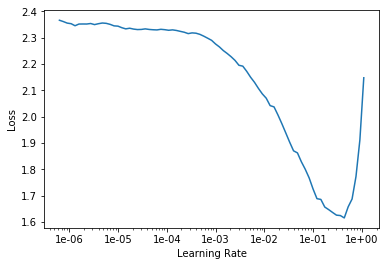

In [0]:
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('10train_wiki_char_cls_1')

epoch,train_loss,valid_loss,accuracy,time
0,0.428067,0.158454,0.951435,22:21
1,0.209186,0.131553,0.957322,22:37


In [0]:
learn_cls.load('10train_wiki_char_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_cls.save('10train_wiki_char_cls_2')

epoch,train_loss,valid_loss,accuracy,time
0,0.261412,0.128277,0.959529,23:26
1,0.105056,0.086605,0.977189,23:21


In [0]:
learn_cls.load('10train_wiki_char_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_cls.save('10train_wiki_char_cls_3')

epoch,train_loss,valid_loss,accuracy,time
0,0.097550,0.075663,0.982340,27:41
1,0.065237,0.068933,0.982340,27:33


In [0]:
learn_cls.load('10train_wiki_char_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('10train_wiki_char_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.047410,0.063220,0.983076,30:49
1,0.041408,0.060616,0.983076,31:06
2,0.031586,0.058860,0.984547,31:00
3,0.029813,0.059680,0.983812,31:05


In [0]:
learn_cls.load('10train_wiki_char_cls_4');

In [0]:
preds,targ = testing(subsets/'10test.csv')

1700
Accuracy: 
0.981764705882353
[('shordindu', 'shunil_gongopaddhay'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shordindu', 'shorotchandra'), ('shordindu', 'robindronath'), ('shottojit_roy', 'shomresh'), ('shirshendu', 'robindronath'), ('shirshendu', 'shorotchandra'), ('shirshendu', 'shorotchandra'), ('shirshendu', 'shorotchandra'), ('shirshendu', 'shordindu'), ('shirshendu', 'shorotchandra'), ('toslima_nasrin', 'shirshendu'), ('MZI', 'humayun_ahmed'), ('MZI', 'humayun_ahmed'), ('shorotchandra', 'shunil_gongopaddhay'), ('robindronath', 'shorotchandra'), ('robindronath', 'shorotchandra'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'toslima_nasrin'), ('humayun_ahmed', 'toslima_nasrin'), ('humayun_ahmed', 'shunil_gongopaddhay'), ('shomresh', 'shirshendu'), ('shomresh', 'shordindu'), ('shomresh', 'shunil_gongopaddhay'), ('shunil_gongopaddhay', 'shomresh'), ('shunil_gongopaddhay', 'shomresh'), ('shunil_gongopaddhay', 'humayun_ahmed'), ('sh

In [0]:
from sklearn.metrics import f1_score
out  = f1_score(targ, preds, average='macro') #'macro' , also == weighted cuz dataset is balanced
out

0.981766387025689

## 12 Authors

### FineTune LM

In [0]:
bs = 128
data_lm=load_data(subsets,'12train_char_lm.pkl',bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,ন ে স ত ্ য ে র এ ই প ্ র ত ্ য ক ্ ষ প ্ র ক া শ দ ে খ ত ে আ ম া র ভ া র ি চ ম ৎ ক া র ল া গ ছ ে xxunk
1,ে ম ি ত ে প ৌ xxunk ছ ে দ ি ত ে প া র ল ে অ ন ে ক ক ি ছ ু জ া ন া য া ব ে xxunk ক ্ য া প ্ ট ে ন ব xxunk ্ ক ে ন
2,ম ু ক ু ল ি ত য ে দ ি ন প া xxunk ড় ে গ ো ষ ্ ঠ ী প া ক া ব া xxunk শ ে র ল া ঠ ি হ া ত ে ক র ি য় া দ ে ব ে
3,ত া হ া র ম দ গ xxunk ্ ব ্ ব ল া ঘ ব ক র ি ত ে হ ই ব ে ; এ ব ন ে র অ ধ ী শ ্ ব র ক ে ত া হ া জ া ন া ই
4,". ব ই ল া ক ি ট া ন ট া দ ি ছ ে দ ে খ xxunk ক ম ল দ া শ গ ু প ্ ত য ে দ ি ন ম া র া গ ে ল , ত া র ক"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=False, drop_mult=0.5)
learn.load(wiki/'models'/'wiki_char_15');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


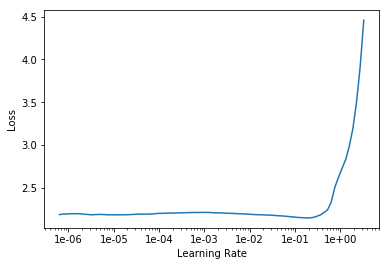

In [0]:
learn.lr_find()
learn.recorder.plot()

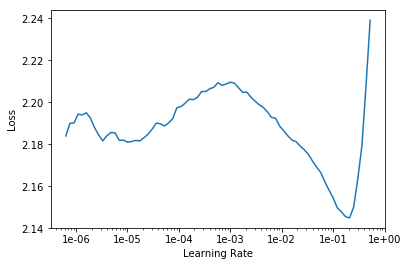

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('12train_wiki_char_lm_head');

epoch,train_loss,valid_loss,accuracy,time
0,1.685606,1.636618,0.525005,17:23
1,1.688103,1.629727,0.526762,17:24


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-2)
learn.save('12train_wiki_char_lm_body_1');

epoch,train_loss,valid_loss,accuracy,time
0,1.439363,1.401545,0.587983,18:19
1,1.396781,1.351138,0.601340,18:13


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-2)
learn.save('12train_wiki_char_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,1.393661,1.352099,0.601683,21:04
1,1.324733,1.283531,0.619742,21:06


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('12train_wiki_char_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,1.342953,1.324380,0.608815,23:10
1,1.351271,1.297441,0.616355,23:06
2,1.290909,1.258543,0.626739,23:08
3,1.249805,1.236201,0.633263,23:10


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('12train_wiki_char_lm_body_4');

epoch,train_loss,valid_loss,accuracy,time
0,1.312294,1.292552,0.617875,23:11
1,1.306026,1.282812,0.620403,23:11
2,1.253826,1.238188,0.632648,23:11
3,1.216095,1.218671,0.638495,23:11


In [0]:
learn.save_encoder('12train_wiki_char_lm_enc')

### Classification (OUR AA)

In [0]:
data_clas=load_data(subsets,'12train_char_clas.pkl',bs=32)

In [0]:
data_clas.show_batch()

text,target
"xxbos x x b o s এ ক ন া প ি ত া ন ী আ স ি ল xxunk ন া প ি ত া ন ী স ধ ব া , খ া ট ো র া ঙ ্ গ া প ে ড় ে স া ড় ী প র",bongkim
xxbos x x b o s : গ ৃ হ া ভ ি ম ু খ ে “ xxunk ” ক প া ল ক ু ণ ্ ড ল া ধ ী র ে ধ ী র ে গ ৃ হ া ভ ি ম ু খ ে চ,bongkim
xxbos x x b o s ক র ি ত ে ছ ে xxunk আ ম া র অ স ি - ফ ল ক অ ঙ ্ গ া র হ ই ত ে ব া হ ি র ক র ি য় া র স া য় ন - ম ি শ,shordindu
xxbos x x b o s ন ি র ্ ব ি ঘ ্ ন ে ন ি ষ ্ ক ্ র া ন ্ ত হ ই ল ে ন xxunk ব ি ম ল া ফ ট ক হ ই ত ে ক ি য় দ ্ দ ূ র গ,bongkim
"xxbos x x b o s ক র ি ল ে ন xxunk ক থ ি ত ব া ল ু ক া স ্ ত ূ প শ ্ র ে ণ ী প ্ র স ্ থ ে অ ত ি অ ল ্ প , অ ত এ ব ন",bongkim


In [0]:
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('12train_wiki_char_lm_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


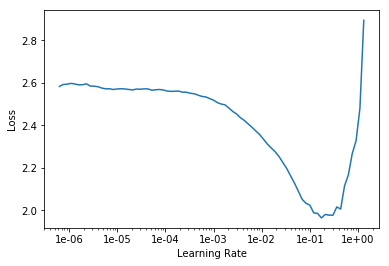

In [0]:
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('12train_wiki_char_cls_1')

epoch,train_loss,valid_loss,accuracy,time
0,0.716062,0.288703,0.914657,17:50
1,0.392272,0.231807,0.916512,17:44


In [0]:
learn_cls.load('12train_wiki_char_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_cls.save('12train_wiki_char_cls_2')

epoch,train_loss,valid_loss,accuracy,time
0,0.399210,0.235063,0.927644,18:21
1,0.225588,0.141789,0.949907,18:42


In [0]:
learn_cls.load('12train_wiki_char_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_cls.save('12train_wiki_char_cls_3')

epoch,train_loss,valid_loss,accuracy,time
0,0.165076,0.139261,0.954545,21:26
1,0.100987,0.085420,0.970315,21:42


In [0]:
learn_cls.load('12train_wiki_char_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('12train_wiki_char_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.077222,0.093411,0.962894,24:19
1,0.068773,0.088996,0.968460,24:11
2,0.064181,0.084821,0.966605,24:22
3,0.052268,0.083612,0.969388,24:28


In [0]:
preds,targ = testing(subsets/'12test.csv')

1356
Accuracy: 
0.9778761061946902
[('tarashonkor', 'shottojit_roy'), ('shordindu', 'bongkim'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shirshendu', 'shomresh'), ('shirshendu', 'shottojit_roy'), ('toslima_nasrin', 'shunil_gongopaddhay'), ('shorotchandra', 'robindronath'), ('shorotchandra', 'robindronath'), ('shorotchandra', 'tarashonkor'), ('shorotchandra', 'robindronath'), ('shorotchandra', 'robindronath'), ('robindronath', 'shorotchandra'), ('robindronath', 'humayun_ahmed'), ('robindronath', 'tarashonkor'), ('robindronath', 'shomresh'), ('robindronath', 'shunil_gongopaddhay'), ('robindronath', 'tarashonkor'), ('robindronath', 'shunil_gongopaddhay'), ('robindronath', 'bongkim'), ('robindronath', 'shordindu'), ('robindronath', 'tarashonkor'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'shirshendu'), ('humayun_ahmed', 'toslima_nasrin'), ('shunil_gongopaddhay', 'robindronath'), ('shunil_gongopaddhay', 

In [0]:
from sklearn.metrics import f1_score
out  = f1_score(targ, preds, average='macro')
out

0.9778052374920407

## 14 Authors

### FineTune LM

In [0]:
bs = 128
data_lm=load_data(subsets,'14train_char_lm.pkl',bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,ঠ ে ব স া র প র ভ ি ড় ট া প া ত ল া হ চ ্ ছ ে xxunk ক ে এ ক জ ন ত া র হ া ত ে র ও প র ে র দ ি ক ট া
1,ছ ি ল xxunk অ ফ ি স থ ে ক ে ব ে র ু ন ো র স ম য় স ে চ ল ে এ স ে ছ ি ল ফ া ই ল প ত ্ র ত ু ল ে র া খ ত ে
2,ত া ক ি ছ ু ই ন য় xxunk আ র এ ট ু ক ু প া চ ্ ছ ে ন ব ল ে ক ো ন ম ত ে চ ল ে য া চ ্ ছ ে xxunk আ দ া য ় ী ক
3,হ ব ে xxunk ক ে উ ল জ ্ জ া য় ভ য় ে ঘ র থ ে ক ে ব ে র ো ত ে প া র ছ ে ন া xxunk ত ো ম া র ব ো ন ে র
4,ে ছ ি ল xxunk স ে ই অ গ ্ ন ি র দ ী প ্ ত ি ল ক ্ ষ ্ য ক র ি য় া ন ব ক ু ম া র স ে স ্ থ ল ে আ স ি ত ে


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=False, drop_mult=0.5)
learn.load(char/'models'/'news_char_3less_15');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


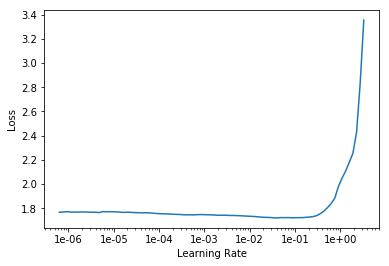

In [0]:
learn.lr_find()
learn.recorder.plot()

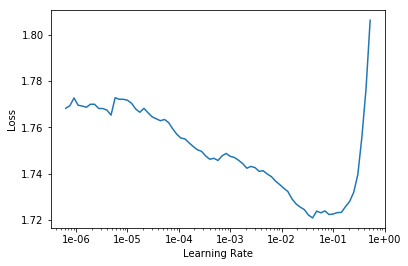

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('14train_wiki_char_lm_head');

epoch,train_loss,valid_loss,accuracy,time
0,1.657691,1.593166,0.537391,17:05
1,1.637628,1.589576,0.538047,17:15


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-2)
learn.save('14train_wiki_char_lm_body_1');

epoch,train_loss,valid_loss,accuracy,time
0,1.434024,1.394284,0.589516,17:52
1,1.393928,1.344717,0.602779,17:52


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-2)
learn.save('14train_wiki_char_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,1.382952,1.353202,0.600079,20:35
1,1.321820,1.289063,0.617887,20:37


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('14train_wiki_char_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,1.343819,1.329256,0.607220,22:40
1,1.334969,1.315945,0.610692,22:38
2,1.300583,1.269911,0.623351,22:43
3,1.247003,1.251128,0.628738,22:46


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('14train_wiki_char_lm_body_4');

epoch,train_loss,valid_loss,accuracy,time
0,1.324841,1.304234,0.614210,22:46
1,1.319135,1.292068,0.617512,22:43
2,1.281757,1.256792,0.627115,22:43
3,1.242562,1.238823,0.632469,22:44


In [0]:
learn.save_encoder('14train_wiki_char_lm_enc')

### Classification (OUR AA)

In [0]:
data_clas = load_data(subsets, '14train_char_clas.pkl',bs=32)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('14train_wiki_char_lm_enc')

In [0]:
data_clas.show_batch()

text,target
"xxbos x x b o s শ ো ব ে ন ? ” শ ্ র ী শ চ ন ্ দ ্ র ব ল ি ল ে ন , “ এ স ো , আ ম র া স ব প র ি ষ ্ ক া র ক র ি",bongkim
"xxbos x x b o s স ্ থ া প ি ত হ ই ল xxunk শ ৈ ব ল ি ন ী ত া হ া প র ি ধ া ন ক র ি য় া , প ূ র ্ ব ব স ্ ত ্ র প র ি",bongkim
"xxbos x x b o s ক র ি ল ে ন xxunk ক থ ি ত ব া ল ু ক া স ্ ত ূ প শ ্ র ে ণ ী প ্ র স ্ থ ে অ ত ি অ ল ্ প , অ ত এ ব ন",bongkim
"xxbos x x b o s প ্ র য ু ক ্ ত ই হ উ ক , ব ি ম ল া ব হ ি র ্ গ ম ন ক া ল ে জ া ল র ন ্ ধ ্ র প থ প ূ র ্ ব ব ৎ অ ব",bongkim
xxbos x x b o s প া র ি ল া ম ন া xxunk এ স ক ল এ ই অ ঙ ্ গ ে র ই উ প য ু ক ্ ত xxunk এ ই জ ন ্ য প র া ই ল,bongkim


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


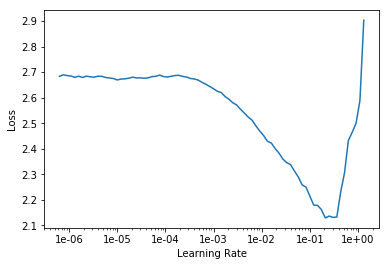

In [0]:
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('14train_wiki_char_cls_1')

epoch,train_loss,valid_loss,accuracy,time
0,1.021297,0.431828,0.882017,17:23
1,0.576011,0.269914,0.929591,17:19


In [0]:
learn_cls.load('14train_wiki_char_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_cls.save('14train_wiki_char_cls_2')

epoch,train_loss,valid_loss,accuracy,time
0,0.515230,0.252446,0.916270,18:21
1,0.278787,0.164087,0.960990,17:56


In [0]:
learn_cls.load('14train_wiki_char_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_cls.save('14train_wiki_char_cls_3')

epoch,train_loss,valid_loss,accuracy,time
0,0.233999,0.138100,0.959087,20:58
1,0.129134,0.104641,0.972407,21:20


In [0]:
learn_cls.load('14train_wiki_char_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('14train_wiki_char_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.115740,0.104923,0.971456,23:32
1,0.092901,0.099471,0.975262,23:45
2,0.085901,0.097677,0.974310,23:32
3,0.068543,0.100042,0.972407,23:43


In [0]:
preds,targ = testing(subsets/'14test.csv')

1316
Accuracy: 
0.9711246200607903
[('manik_bandhopaddhay', 'shirshendu'), ('manik_bandhopaddhay', 'toslima_nasrin'), ('manik_bandhopaddhay', 'shirshendu'), ('nihar_ronjon_gupta', 'shunil_gongopaddhay'), ('tarashonkor', 'shirshendu'), ('tarashonkor', 'shorotchandra'), ('tarashonkor', 'nihar_ronjon_gupta'), ('tarashonkor', 'nihar_ronjon_gupta'), ('tarashonkor', 'shunil_gongopaddhay'), ('shordindu', 'bongkim'), ('shottojit_roy', 'humayun_ahmed'), ('shottojit_roy', 'nihar_ronjon_gupta'), ('shirshendu', 'robindronath'), ('shirshendu', 'tarashonkor'), ('shirshendu', 'humayun_ahmed'), ('shirshendu', 'shorotchandra'), ('toslima_nasrin', 'shottojit_roy'), ('toslima_nasrin', 'humayun_ahmed'), ('toslima_nasrin', 'humayun_ahmed'), ('toslima_nasrin', 'humayun_ahmed'), ('toslima_nasrin', 'manik_bandhopaddhay'), ('toslima_nasrin', 'shirshendu'), ('toslima_nasrin', 'shomresh'), ('toslima_nasrin', 'manik_bandhopaddhay'), ('shorotchandra', 'bongkim'), ('shorotchandra', 'tarashonkor'), ('robindronath', 

In [0]:
from sklearn.metrics import f1_score
out  = f1_score(targ, preds, average='macro') #'macro' , also == weighted cuz dataset is balanced
out

0.9710427203396331